In [1]:
import warnings
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Reshape, Dropout, average, Activation
from tensorflow.keras.applications import vgg16, resnet50, efficientnet
import tensorflow as tf


warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')


ModuleNotFoundError: No module named 'matplotlib'

In [67]:
# Load dataset and split to train, test
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, IMAGE_SIZE, BATCH_SIZE):

    train_datagen = ImageDataGenerator(shear_range=0.2,
                                       zoom_range=0.3,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       brightness_range=[0.2, 1.2],
                                       rotation_range=0.2,
                                       horizontal_flip=True)
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        classes=CLASSES,
                                                        target_size=IMAGE_SIZE)

    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      classes=CLASSES,
                                                      target_size=IMAGE_SIZE)

    return train_generator, test_generator


In [68]:
# Load dataset and split to train, test for bagging ensemble
def train_val_generators_bagging(TRAINING_DIR, VALIDATION_DIR, IMAGE_SIZE, BATCH_SIZE):

    train_datagen = ImageDataGenerator(validation_split=0.1,
                                       shear_range=0.2,
                                       zoom_range=0.3,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       brightness_range=[0.2, 1.2],
                                       rotation_range=0.2,
                                       horizontal_flip=True)
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        subset='validation',
                                                        shuffle=True,
                                                        classes=CLASSES,
                                                        target_size=IMAGE_SIZE)

    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      classes=CLASSES,
                                                      target_size=IMAGE_SIZE)

    return train_generator, test_generator


In [69]:
# Plot training result
def plot_training_result(history):

    metrics = ['accuracy', 'loss', 'precision', 'recall']
    for metric in metrics:
        plt.plot(history.history[metric])
        plt.plot(history.history[f'val_{metric}'])
        plt.title(f'Model {metric}')
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

# Plot model structure, save to a folder and create folder if folder is not existed


def plot_model_structure(model):
    folder_path = "./model_structure"

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    model_structure_path = f'{folder_path}/{model.name}.png'
    return plot_model(model, model_structure_path, show_shapes=True)


In [70]:
# Save model weights and create folder if folder is not existed
def save_model_weights(model):
    folder_path = "./model_weights"

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    model_weights_path = f'{folder_path}/{model.name}.weights.h5'
    model.save_weights(model_weights_path, overwrite=True)
    print(f'Saved model to: {model_weights_path}')


In [71]:
def load_model_weights(model):
    folder_path = "./model_weights"

    model_weights_path = f'{folder_path}/{model.name}.weights.h5'
    model.load_weights(model_weights_path)


def download_model_weights(model):
    folder_path = "./model_weights"

    model_weights_path = f'{folder_path}/{model.name}.weights.h5'
    files.download(model_weights_path)


In [72]:
# Function build a VGG16 transfer learning model
def build_vgg16_tl(name='vgg16_tl'):
    input_layer = Input(shape=INPUT_SHAPE)

    vgg16_model = vgg16.VGG16(
        weights='imagenet', include_top=False, pooling='avg', input_shape=INPUT_SHAPE)
    vgg16_model.trainable = False

    vgg16_tl = vgg16.preprocess_input(input_layer)
    vgg16_tl = vgg16_model(vgg16_tl)
    vgg16_tl = Dense(4096, activation='relu')(vgg16_tl)
    vgg16_tl = Dense(1072, activation='relu')(vgg16_tl)
    vgg16_tl = Dropout(0.2)(vgg16_tl)
    vgg16_tl = Dense(len(CLASSES), activation='softmax')(vgg16_tl)

    vgg16_tl_model = Model(inputs=input_layer, outputs=vgg16_tl, name=name)
    vgg16_tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
                           'accuracy', 'precision', 'recall'])

    return vgg16_tl_model


In [73]:
# Function build a ResNet50 transfer learning model
def build_resnet50_tl(name='resnet50_tl'):
    input_layer = Input(shape=INPUT_SHAPE)

    resnet50_model = resnet50.ResNet50(
        weights='imagenet', include_top=False, pooling='avg', input_shape=INPUT_SHAPE)
    resnet50_model.trainable = False

    resnet50_tl = resnet50.preprocess_input(input_layer)
    resnet50_tl = resnet50_model(resnet50_tl)
    resnet50_tl = Dense(4096, activation='relu')(resnet50_tl)
    resnet50_tl = Dense(1072, activation='relu')(resnet50_tl)
    resnet50_tl = Dropout(0.2)(resnet50_tl)
    resnet50_tl = Dense(len(CLASSES), activation='softmax')(resnet50_tl)

    resnet50_tl_model = Model(
        inputs=input_layer, outputs=resnet50_tl, name=name)
    resnet50_tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
                              'accuracy', 'precision', 'recall'])

    return resnet50_tl_model


def build_efficientnetb0_tl(name='efficientnetb0_tl'):
    input_layer = Input(shape=INPUT_SHAPE)

    efficientnetb0_model = efficientnet.EfficientNetB0(
        weights='imagenet', include_top=False, pooling='avg', input_shape=INPUT_SHAPE)
    efficientnetb0_model.trainable = False

    efficientnetb0_tl = efficientnet.preprocess_input(input_layer)
    efficientnetb0_tl = efficientnetb0_model(efficientnetb0_tl)
    efficientnetb0_tl = Dense(4096, activation='relu')(efficientnetb0_tl)
    efficientnetb0_tl = Dense(1072, activation='relu')(efficientnetb0_tl)
    efficientnetb0_tl = Dropout(0.2)(efficientnetb0_tl)
    efficientnetb0_tl = Dense(
        len(CLASSES), activation='softmax')(efficientnetb0_tl)

    efficientnetb0_tl_model = Model(
        inputs=input_layer, outputs=efficientnetb0_tl, name=name)
    efficientnetb0_tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
                                    'accuracy', 'precision', 'recall'])

    return efficientnetb0_tl_model


In [74]:
BATCH_SIZE = 64
IMAGE_SIZE = (200, 150)
TRAIN_PATH = "base_dir/train_dir"
TEST_PATH = "base_dir/val_dir"
INPUT_SHAPE = (200, 150, 3)
CLASSES = [
    'akiec',
    'bcc',
    'bkl',
    'df',
    'mel',
    'nv',
    'vasc',
]


In [75]:
train_generator, test_generator = train_val_generators(
    TRAIN_PATH, TEST_PATH, IMAGE_SIZE, BATCH_SIZE)


Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [76]:
custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    mode='min'
)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss', patience=3, verbose=2, factor=0.5, min_lr=0.00001)


In [77]:
vgg16_tl_model = build_vgg16_tl()
plot_model_structure(vgg16_tl_model)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [78]:
vgg16_tl_history = vgg16_tl_model.fit(train_generator, epochs=60, validation_data=test_generator, callbacks=[
                                      custom_early_stopping, learning_rate_reduction])


Epoch 1/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 2071s 3s/step - accuracy: 0.5055 - loss: 1.7029 - precision: 0.6705 - recall: 0.3125 - val_accuracy: 0.8145 - val_loss: 0.5196 - val_precision: 0.8823 - val_recall: 0.7591 - learning_rate: 0.0010
Epoch 2/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 2430s 4s/step - accuracy: 0.6533 - loss: 0.9160 - precision: 0.7761 - recall: 0.5135 - val_accuracy: 0.8401 - val_loss: 0.5410 - val_precision: 0.8769 - val_recall: 0.8049 - learning_rate: 0.0010
Epoch 3/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 1391s 2s/step - accuracy: 0.6795 - loss: 0.8337 - precision: 0.7860 - recall: 0.5602 - val_accuracy: 0.8166 - val_loss: 0.5833 - val_precision: 0.8570 - val_recall: 0.7601 - learning_rate: 0.0010
Epoch 4/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6976 - loss: 0.7816 - precision: 0.7962 - recall: 0.5941
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
603/603 ━━━━━━━━━━━━━━━━━━━━ 1277s 2s/step - accuracy: 0.6976 - loss: 0.7816 - precision: 0.79

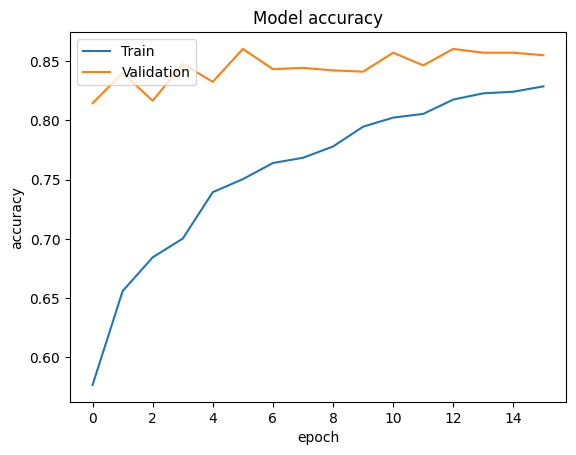

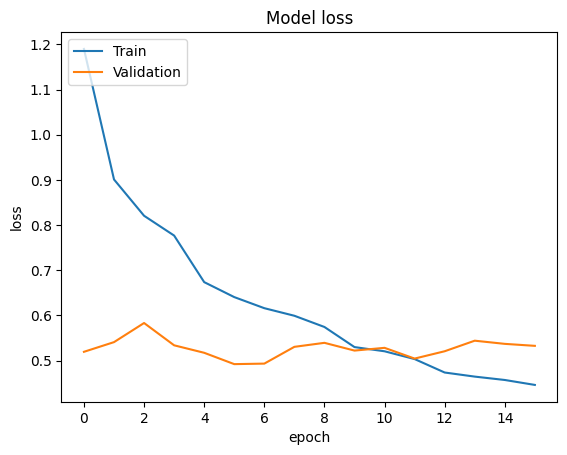

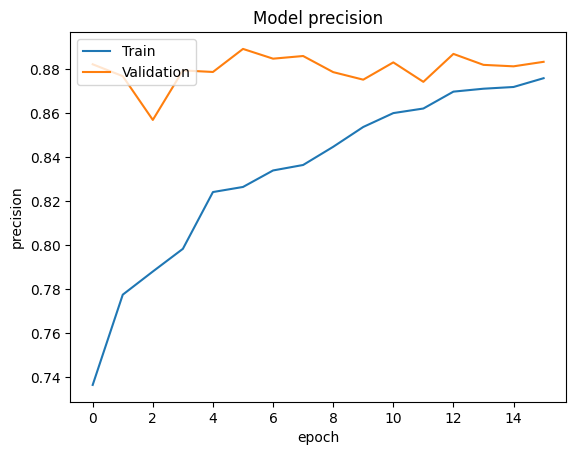

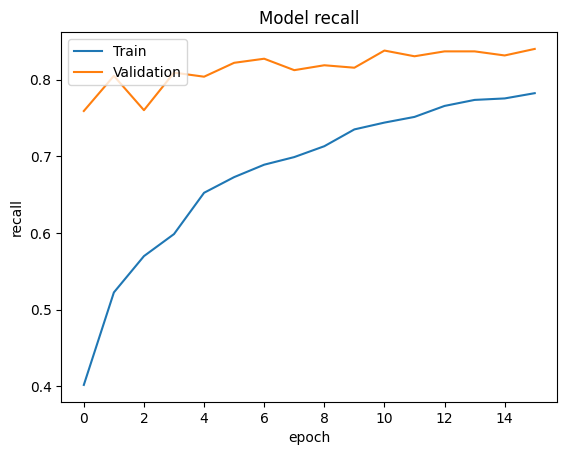

Saved model to: ./model_weights/vgg16_tl.weights.h5


In [79]:
plot_training_result(vgg16_tl_history)


save_model_weights(vgg16_tl_model)


In [80]:
resnet50_tl_model = build_resnet50_tl()
plot_model_structure(resnet50_tl_model)

resnet50_tl_history = resnet50_tl_model.fit(train_generator, epochs=60, validation_data=test_generator, callbacks=[
                                            custom_early_stopping, learning_rate_reduction])


You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 886s 1s/step - accuracy: 0.5487 - loss: 1.3912 - precision: 0.6885 - recall: 0.3894 - val_accuracy: 0.8454 - val_loss: 0.5073 - val_precision: 0.8898 - val_recall: 0.8262 - learning_rate: 0.0010
Epoch 2/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 872s 1s/step - accuracy: 0.7059 - loss: 0.7552 - precision: 0.7900 - recall: 0.6153 - val_accuracy: 0.8742 - val_loss: 0.4239 - val_precision: 0.9001 - val_recall: 0.8550 - learning_rate: 0.0010
Epoch 3/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 871s 1s/step - accuracy: 0.7337 - loss: 0.6749 - precision: 0.8055 - recall: 0.6623 - val_accuracy: 0.8625 - val_loss: 0.4123 - val_precision: 0.8962 - val_recall: 0.8465 - learning_rate: 0.0010
Epoch 4/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 866s 1s/step - accuracy: 0.7628 - loss: 0.6101 - precision: 0.8226 - recall: 0.6994 - val_accuracy: 0.8497 - val_loss: 0.5691 - val_precision: 0.8628 - val_recall: 0.8380 - learning_ra

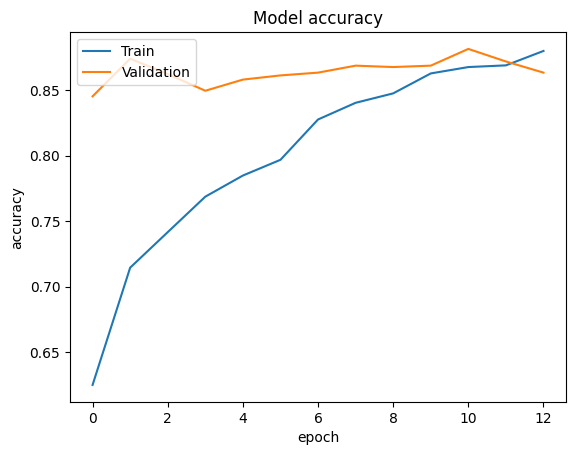

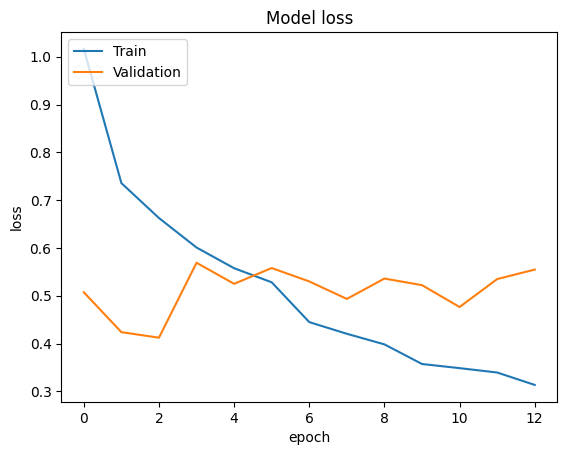

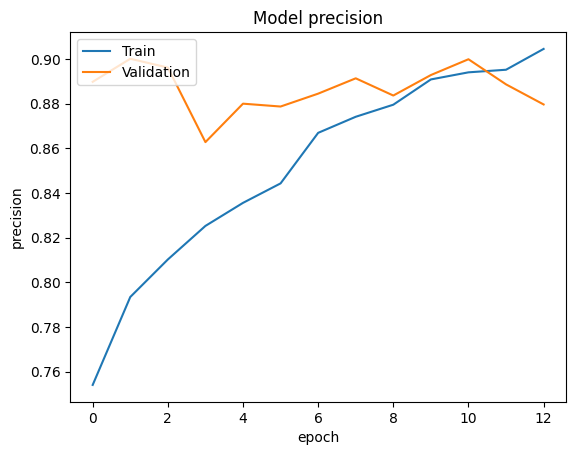

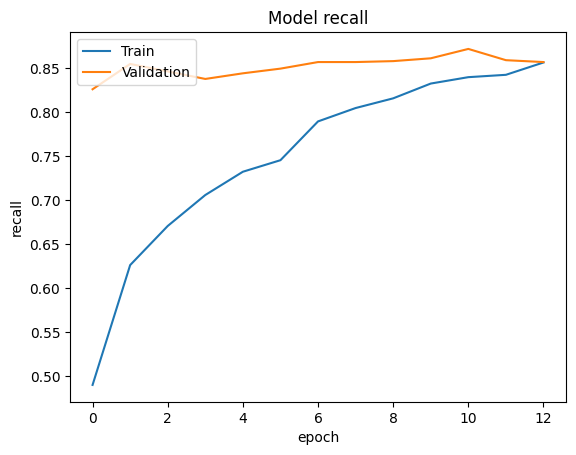

Saved model to: ./model_weights/resnet50_tl.weights.h5


In [81]:
plot_training_result(resnet50_tl_history)

save_model_weights(resnet50_tl_model)


In [82]:
efficientnetb0_tl_model = build_efficientnetb0_tl()
plot_model_structure(efficientnetb0_tl_model)

efficientnetb0_tl_history = efficientnetb0_tl_model.fit(
    train_generator, epochs=60, validation_data=test_generator, callbacks=[custom_early_stopping, learning_rate_reduction])


You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 605s 992ms/step - accuracy: 0.5272 - loss: 1.2292 - precision: 0.7083 - recall: 0.3472 - val_accuracy: 0.8337 - val_loss: 0.5443 - val_precision: 0.8648 - val_recall: 0.8049 - learning_rate: 0.0010
Epoch 2/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 594s 985ms/step - accuracy: 0.6466 - loss: 0.9111 - precision: 0.7660 - recall: 0.5227 - val_accuracy: 0.8284 - val_loss: 0.7447 - val_precision: 0.8440 - val_recall: 0.8134 - learning_rate: 0.0010
Epoch 3/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 593s 984ms/step - accuracy: 0.6804 - loss: 0.8289 - precision: 0.7873 - recall: 0.5670 - val_accuracy: 0.8475 - val_loss: 0.5085 - val_precision: 0.8970 - val_recall: 0.8166 - learning_rate: 0.0010
Epoch 4/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 594s 985ms/step - accuracy: 0.6930 - loss: 0.7935 - precision: 0.7908 - recall: 0.5892 - val_accuracy: 0.8582 - val_loss: 0.5197 - val_precision: 0.8803 - val_recall: 0.8390 -

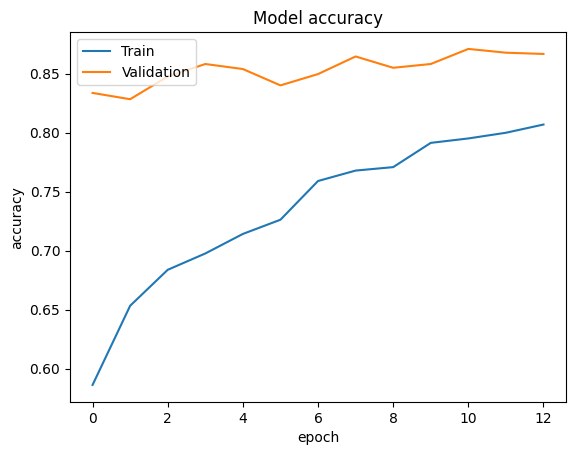

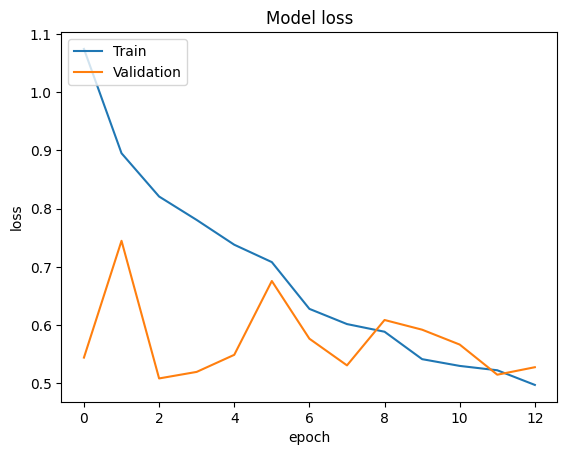

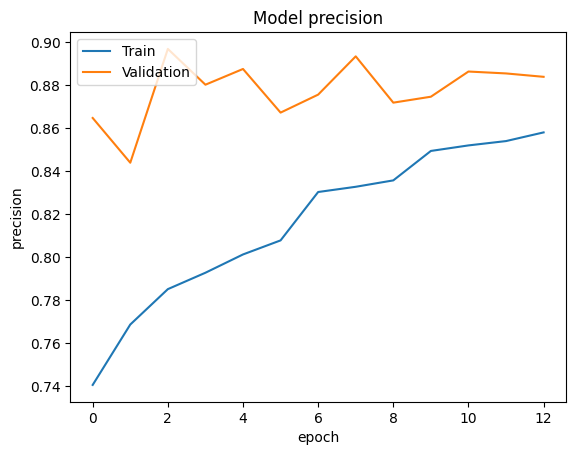

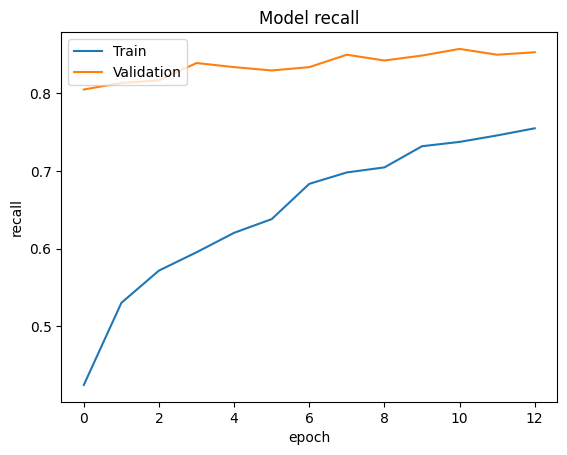

Saved model to: ./model_weights/efficientnetb0_tl.weights.h5


In [83]:
plot_training_result(efficientnetb0_tl_history)

save_model_weights(efficientnetb0_tl_model)


In [84]:
train_generator, test_generator = train_val_generators(
    TRAIN_PATH, TEST_PATH, IMAGE_SIZE, BATCH_SIZE)


Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [85]:
custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    mode='min'
)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss', patience=3, verbose=2, factor=0.5, min_lr=0.00001)


In [87]:
input_layer = Input(shape=INPUT_SHAPE)

vgg16_tl_model = build_vgg16_tl()
load_model_weights(vgg16_tl_model)
vgg16_tl_model.trainable = False

vgg16_tl_model = vgg16_tl_model(input_layer)


In [88]:
resnet50_tl_model = build_resnet50_tl()
load_model_weights(resnet50_tl_model)
resnet50_tl_model.trainable = False

resnet50_tl_model = resnet50_tl_model(input_layer)


In [89]:
vgg16_resnet50_stacking = average([vgg16_tl_model, resnet50_tl_model])
vgg16_resnet50_stacking = Dense(
    4096, activation='relu')(vgg16_resnet50_stacking)
vgg16_resnet50_stacking = Dense(
    1072, activation='relu')(vgg16_resnet50_stacking)
vgg16_resnet50_stacking = Dropout(0.2)(vgg16_resnet50_stacking)
vgg16_resnet50_stacking = Dense(
    len(CLASSES), activation='softmax')(vgg16_resnet50_stacking)

vgg16_resnet50_stacking_model = Model(
    inputs=input_layer, outputs=vgg16_resnet50_stacking, name='vgg16_resnet50_stacking')

vgg16_resnet50_stacking_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
                                      'accuracy', 'precision', 'recall'])
plot_model_structure(vgg16_resnet50_stacking_model)

vgg16_resnet50_stacking_history = vgg16_resnet50_stacking_model.fit(
    train_generator, epochs=60, validation_data=test_generator, callbacks=[custom_early_stopping, learning_rate_reduction])


You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 2031s 3s/step - accuracy: 0.8926 - loss: 0.3684 - precision: 0.9105 - recall: 0.8412 - val_accuracy: 0.8710 - val_loss: 0.5364 - val_precision: 0.8916 - val_recall: 0.8678 - learning_rate: 0.0010
Epoch 2/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 1907s 3s/step - accuracy: 0.8977 - loss: 0.2891 - precision: 0.9158 - recall: 0.8796 - val_accuracy: 0.8763 - val_loss: 0.4742 - val_precision: 0.9006 - val_recall: 0.8689 - learning_rate: 0.0010
Epoch 3/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 1910s 3s/step - accuracy: 0.8955 - loss: 0.2947 - precision: 0.9157 - recall: 0.8756 - val_accuracy: 0.8721 - val_loss: 0.4851 - val_precision: 0.8935 - val_recall: 0.8678 - learning_rate: 0.0010
Epoch 4/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 1911s 3s/step - accuracy: 0.8991 - loss: 0.2828 - precision: 0.9163 - recall: 0.8819 - val_accuracy: 0.8699 - val_loss: 0.4785 - val_precision: 0.8971 - val_recall: 0.8646 - learnin

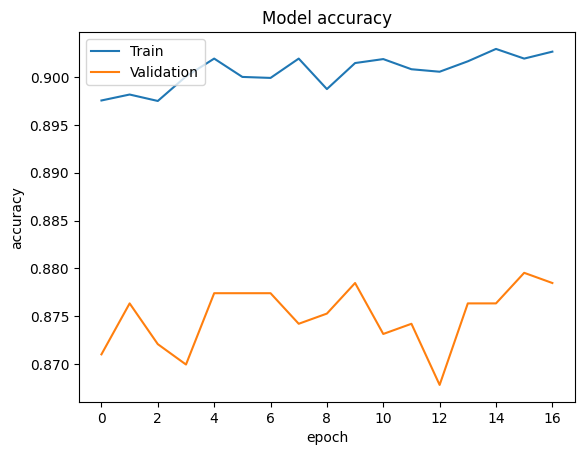

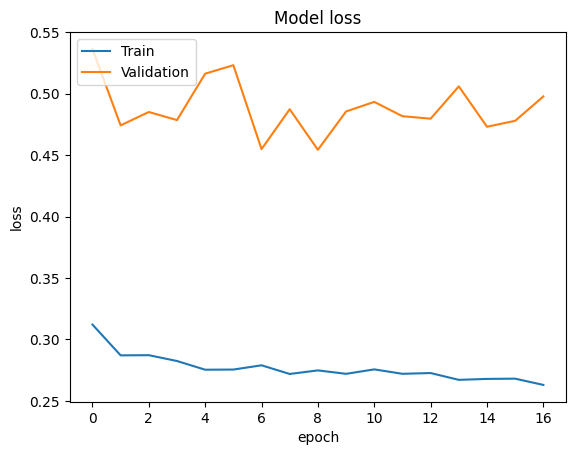

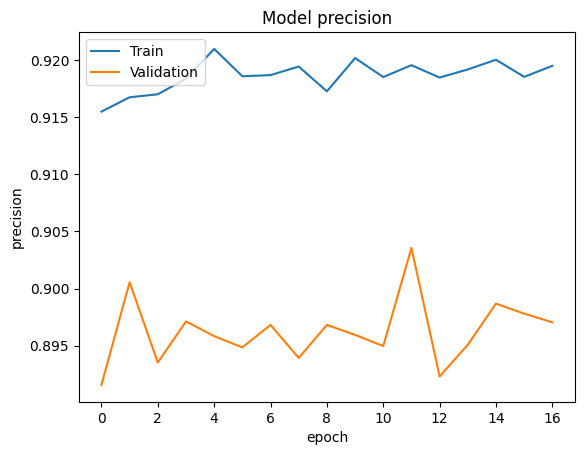

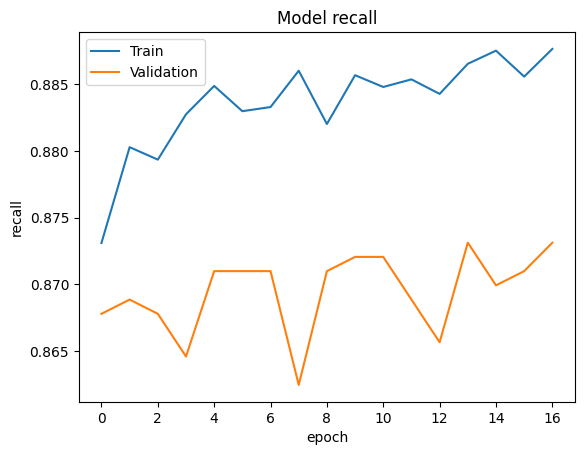

Saved model to: ./model_weights/vgg16_resnet50_stacking.weights.h5


In [90]:
plot_training_result(vgg16_resnet50_stacking_history)

save_model_weights(vgg16_resnet50_stacking_model)


In [91]:
vgg16_tl_model = build_vgg16_tl()
load_model_weights(vgg16_tl_model)
vgg16_tl_model.trainable = False

vgg16_tl_model = vgg16_tl_model(input_layer)


In [92]:
efficientnetb0_tl_model = build_efficientnetb0_tl()
load_model_weights(efficientnetb0_tl_model)
efficientnetb0_tl_model.trainable = False

efficientnetb0_tl_model = efficientnetb0_tl_model(input_layer)

vgg16_efficientnetb0_stacking = average(
    [vgg16_tl_model, efficientnetb0_tl_model])
vgg16_efficientnetb0_stacking = Dense(
    4096, activation='relu')(vgg16_efficientnetb0_stacking)
vgg16_efficientnetb0_stacking = Dense(
    1072, activation='relu')(vgg16_efficientnetb0_stacking)
vgg16_efficientnetb0_stacking = Dropout(0.2)(vgg16_efficientnetb0_stacking)
vgg16_efficientnetb0_stacking = Dense(
    len(CLASSES), activation='softmax')(vgg16_efficientnetb0_stacking)

vgg16_efficientnetb0_stacking_model = Model(
    inputs=input_layer, outputs=vgg16_efficientnetb0_stacking, name='vgg16_efficientnetb0_stacking')

vgg16_efficientnetb0_stacking_model.compile(
    optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])


In [93]:
plot_model_structure(vgg16_efficientnetb0_stacking_model)


You must install pydot (`pip install pydot`) for `plot_model` to work.


Epoch 1/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 1629s 3s/step - accuracy: 0.8560 - loss: 0.4564 - precision: 0.8886 - recall: 0.7950 - val_accuracy: 0.8753 - val_loss: 0.4392 - val_precision: 0.8939 - val_recall: 0.8625 - learning_rate: 0.0010
Epoch 2/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 1608s 3s/step - accuracy: 0.8667 - loss: 0.3679 - precision: 0.8957 - recall: 0.8399 - val_accuracy: 0.8870 - val_loss: 0.5176 - val_precision: 0.9046 - val_recall: 0.8795 - learning_rate: 0.0010
Epoch 3/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 1627s 3s/step - accuracy: 0.8626 - loss: 0.3704 - precision: 0.8943 - recall: 0.8344 - val_accuracy: 0.8838 - val_loss: 0.4496 - val_precision: 0.9005 - val_recall: 0.8785 - learning_rate: 0.0010
Epoch 4/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8671 - loss: 0.3662 - precision: 0.8963 - recall: 0.8405
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
603/603 ━━━━━━━━━━━━━━━━━━━━ 1619s 3s/step - accuracy: 0.8671 - loss: 0.3662 - precision: 0.89

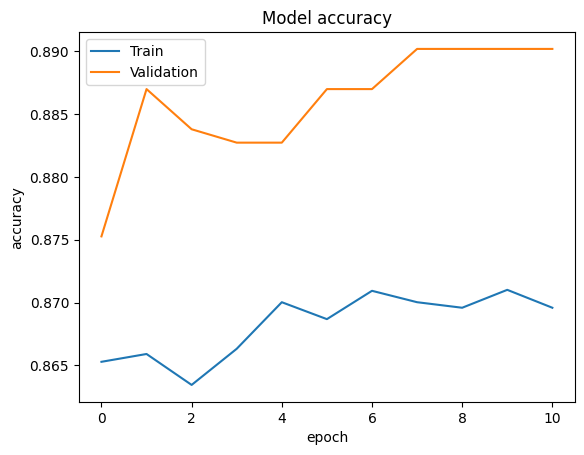

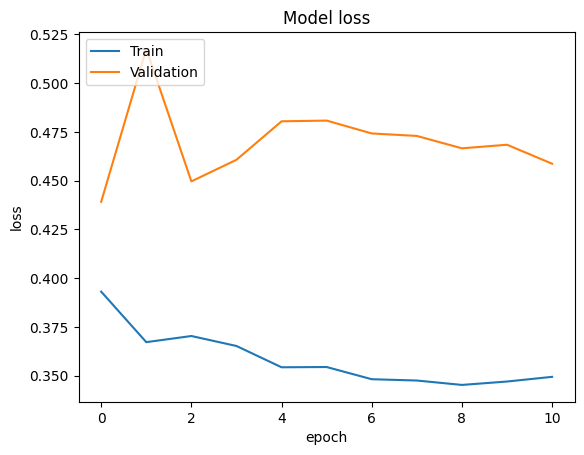

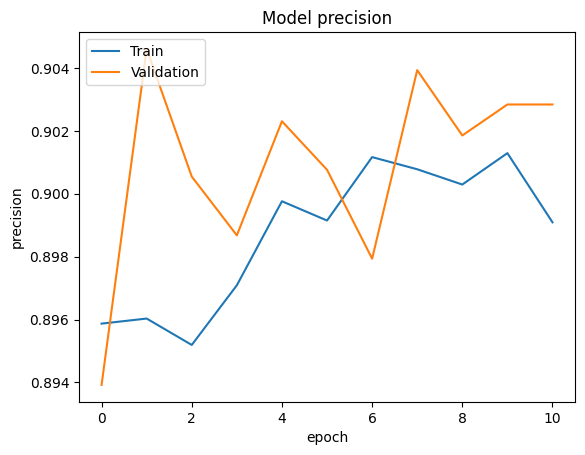

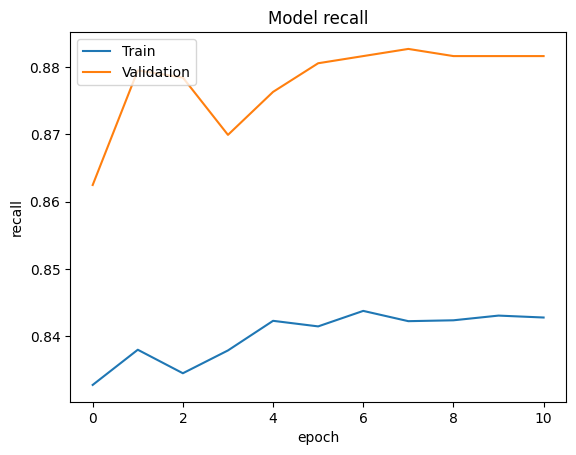

In [94]:
vgg16_efficientnetb0_stacking_history = vgg16_efficientnetb0_stacking_model.fit(
    train_generator, epochs=60, validation_data=test_generator, callbacks=[custom_early_stopping, learning_rate_reduction])

plot_training_result(vgg16_efficientnetb0_stacking_history)


In [95]:
save_model_weights(vgg16_efficientnetb0_stacking_model)


Saved model to: ./model_weights/vgg16_efficientnetb0_stacking.weights.h5


In [96]:
input_layer = Input(shape=INPUT_SHAPE)

resnet50_tl_model = build_resnet50_tl()
load_model_weights(resnet50_tl_model)
resnet50_tl_model.trainable = False

resnet50_tl_model = resnet50_tl_model(input_layer)

efficientnetb0_tl_model = build_efficientnetb0_tl()
load_model_weights(efficientnetb0_tl_model)


You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 1419s 2s/step - accuracy: 0.8801 - loss: 0.4013 - precision: 0.9037 - recall: 0.8300 - val_accuracy: 0.8785 - val_loss: 0.4887 - val_precision: 0.8957 - val_recall: 0.8699 - learning_rate: 0.0010
Epoch 2/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 1362s 2s/step - accuracy: 0.8906 - loss: 0.3076 - precision: 0.9110 - recall: 0.8710 - val_accuracy: 0.8806 - val_loss: 0.4758 - val_precision: 0.8939 - val_recall: 0.8710 - learning_rate: 0.0010
Epoch 3/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 1245s 2s/step - accuracy: 0.8932 - loss: 0.3063 - precision: 0.9130 - recall: 0.8731 - val_accuracy: 0.8753 - val_loss: 0.4994 - val_precision: 0.8909 - val_recall: 0.8710 - learning_rate: 0.0010
Epoch 4/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 1235s 2s/step - accuracy: 0.8906 - loss: 0.2995 - precision: 0.9105 - recall: 0.8727 - val_accuracy: 0.8763 - val_loss: 0.5363 - val_precision: 0.8909 - val_recall: 0.8710 - learnin

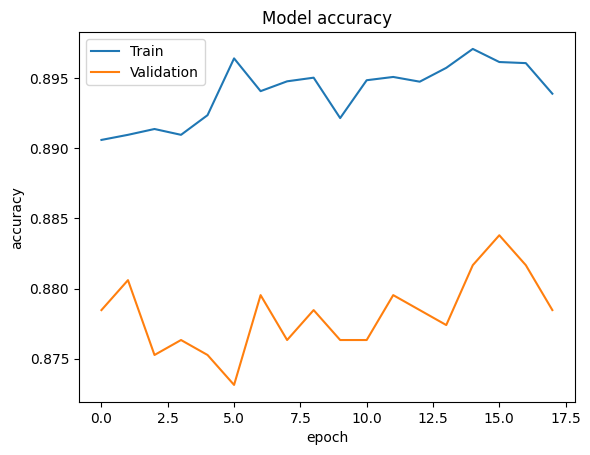

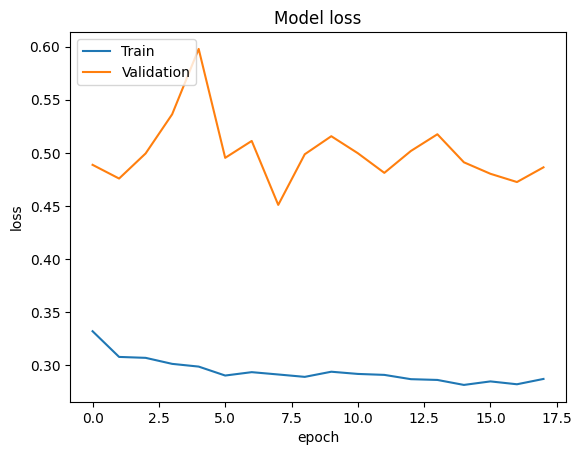

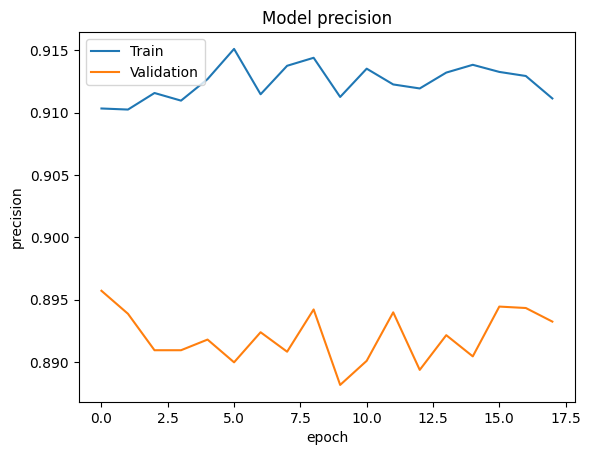

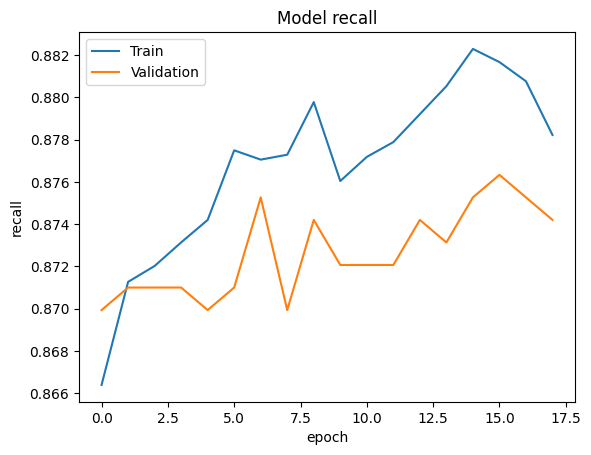

In [97]:
efficientnetb0_tl_model.trainable = False

efficientnetb0_tl_model = efficientnetb0_tl_model(input_layer)

resnet50_efficientnetb0_stacking = average(
    [resnet50_tl_model, efficientnetb0_tl_model])
resnet50_efficientnetb0_stacking = Dense(
    4096, activation='relu')(resnet50_efficientnetb0_stacking)
resnet50_efficientnetb0_stacking = Dense(
    1072, activation='relu')(resnet50_efficientnetb0_stacking)
resnet50_efficientnetb0_stacking = Dropout(
    0.2)(resnet50_efficientnetb0_stacking)
resnet50_efficientnetb0_stacking = Dense(
    len(CLASSES), activation='softmax')(resnet50_efficientnetb0_stacking)

resnet50_efficientnetb0_stacking_model = Model(
    inputs=input_layer, outputs=resnet50_efficientnetb0_stacking, name='resnet50_efficientnetb0_stacking')

resnet50_efficientnetb0_stacking_model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])
plot_model_structure(resnet50_efficientnetb0_stacking_model)

resnet50_efficientnetb0_stacking_history = resnet50_efficientnetb0_stacking_model.fit(
    train_generator, epochs=60, validation_data=test_generator, callbacks=[custom_early_stopping, learning_rate_reduction])

plot_training_result(resnet50_efficientnetb0_stacking_history)


In [98]:
save_model_weights(resnet50_efficientnetb0_stacking_model)

input_layer = Input(shape=INPUT_SHAPE)


Saved model to: ./model_weights/resnet50_efficientnetb0_stacking.weights.h5


In [99]:
vgg16_tl_model = build_vgg16_tl()
load_model_weights(vgg16_tl_model)
vgg16_tl_model.trainable = False

vgg16_tl_model = vgg16_tl_model(input_layer)

resnet50_tl_model = build_resnet50_tl()
load_model_weights(resnet50_tl_model)
resnet50_tl_model.trainable = False

resnet50_tl_model = resnet50_tl_model(input_layer)

efficientnetb0_tl_model = build_efficientnetb0_tl()
load_model_weights(efficientnetb0_tl_model)
efficientnetb0_tl_model.trainable = False

efficientnetb0_tl_model = efficientnetb0_tl_model(input_layer)

vgg16_resnet50_efficientnetb0_stacking = average(
    [vgg16_tl_model, resnet50_tl_model, efficientnetb0_tl_model])
vgg16_resnet50_efficientnetb0_stacking = Dense(
    4096, activation='relu')(vgg16_resnet50_efficientnetb0_stacking)
vgg16_resnet50_efficientnetb0_stacking = Dense(
    1072, activation='relu')(vgg16_resnet50_efficientnetb0_stacking)
vgg16_resnet50_efficientnetb0_stacking = Dropout(
    0.2)(vgg16_resnet50_efficientnetb0_stacking)
vgg16_resnet50_efficientnetb0_stacking = Dense(
    len(CLASSES), activation='softmax')(vgg16_resnet50_efficientnetb0_stacking)

vgg16_resnet50_efficientnetb0_stacking_model = Model(
    inputs=input_layer, outputs=vgg16_resnet50_efficientnetb0_stacking, name='vgg16_resnet50_efficientnetb0_stacking')

vgg16_resnet50_efficientnetb0_stacking_model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])


You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 2257s 4s/step - accuracy: 0.8897 - loss: 0.3710 - precision: 0.9090 - recall: 0.8358 - val_accuracy: 0.8934 - val_loss: 0.4375 - val_precision: 0.9053 - val_recall: 0.8870 - learning_rate: 0.0010
Epoch 2/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 2290s 4s/step - accuracy: 0.9003 - loss: 0.2738 - precision: 0.9173 - recall: 0.8836 - val_accuracy: 0.8881 - val_loss: 0.4402 - val_precision: 0.9036 - val_recall: 0.8795 - learning_rate: 0.0010
Epoch 3/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 2298s 4s/step - accuracy: 0.9051 - loss: 0.2672 - precision: 0.9234 - recall: 0.8904 - val_accuracy: 0.8913 - val_loss: 0.4301 - val_precision: 0.9010 - val_recall: 0.8827 - learning_rate: 0.0010
Epoch 4/60
603/603 ━━━━━━━━━━━━━━━━━━━━ 2302s 4s/step - accuracy: 0.9017 - loss: 0.2709 - precision: 0.9191 - recall: 0.8831 - val_accuracy: 0.8891 - val_loss: 0.4654 - val_precision: 0.9037 - val_recall: 0.8806 - learnin

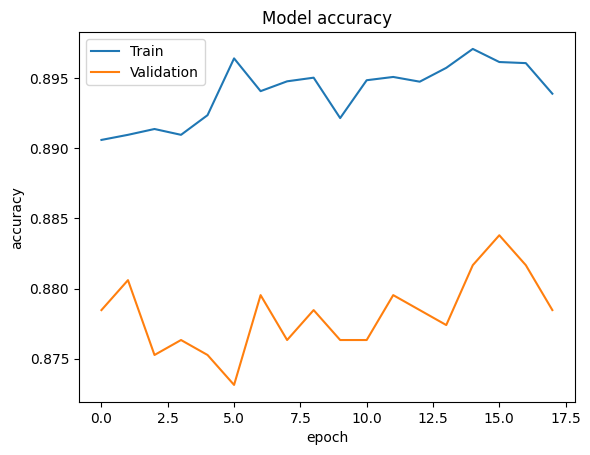

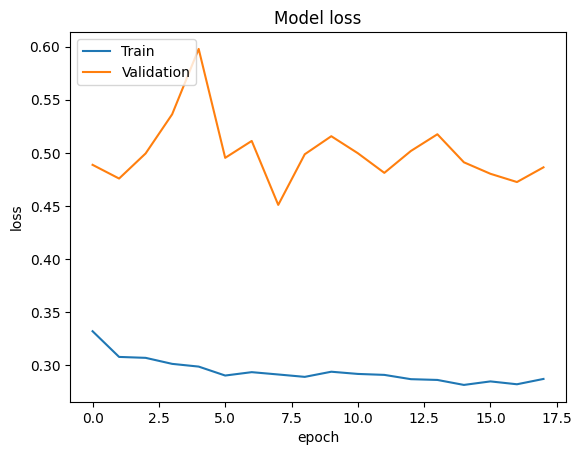

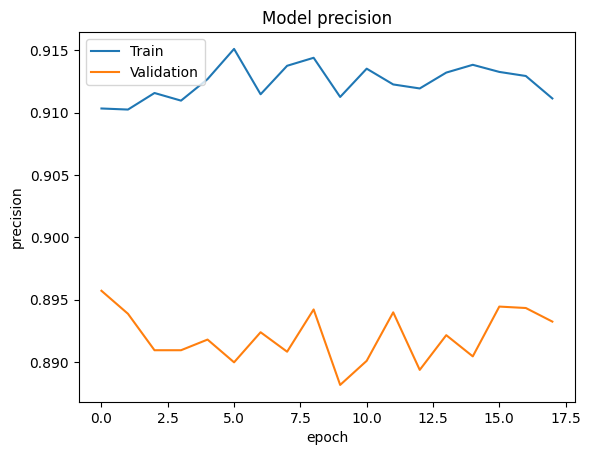

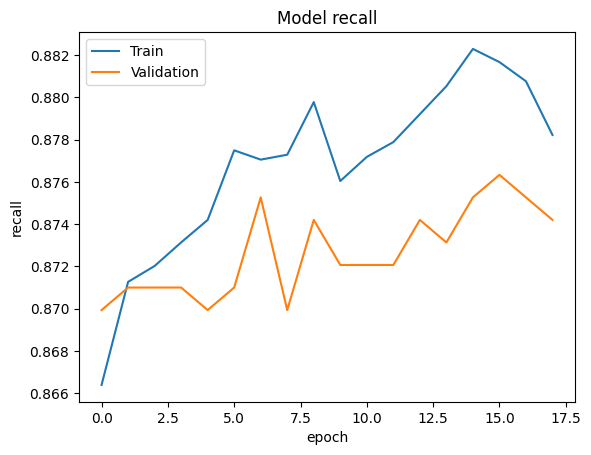

Saved model to: ./model_weights/vgg16_resnet50_efficientnetb0_stacking.weights.h5


In [100]:
plot_model_structure(vgg16_resnet50_efficientnetb0_stacking_model)

vgg16_resnet50_efficientnetb0_stacking_history = vgg16_resnet50_efficientnetb0_stacking_model.fit(
    train_generator, epochs=60, validation_data=test_generator, callbacks=[custom_early_stopping, learning_rate_reduction])

plot_training_result(resnet50_efficientnetb0_stacking_history)

save_model_weights(vgg16_resnet50_efficientnetb0_stacking_model)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss', patience=3, verbose=2, factor=0.5, min_lr=0.00001)

test_generator = None


In [101]:
for i in range(1, 11):
    train_generator, test_generator = train_val_generators_bagging(
        TRAIN_PATH, TEST_PATH, IMAGE_SIZE, BATCH_SIZE)

    print(f"Train model number {i}")
    vgg16_tl_model = build_vgg16_tl(f"vgg16_tl_bagging{i}")

    vgg16_tl_model.fit(train_generator, epochs=5, validation_data=test_generator, callbacks=[
                       learning_rate_reduction])
    save_model_weights(vgg16_tl_model)

input_layer = Input(shape=INPUT_SHAPE)

small_vgg16_tl_models = []
for i in range(1, 11):
    vgg16_tl_model = build_vgg16_tl(f'vgg16_tl_bagging{i}')
    load_model_weights(vgg16_tl_model)
    vgg16_tl_model.trainable = False
    vgg16_tl_model = vgg16_tl_model(input_layer)

    small_vgg16_tl_models.append(vgg16_tl_model)


Found 3855 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Train model number 1
Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.3408 - loss: 3.4809 - precision: 0.4207 - recall: 0.1980 - val_accuracy: 0.7740 - val_loss: 0.7240 - val_precision: 0.8725 - val_recall: 0.7004 - learning_rate: 0.0010
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.5746 - loss: 1.1142 - precision: 0.7583 - recall: 0.3937 - val_accuracy: 0.7846 - val_loss: 0.6249 - val_precision: 0.8771 - val_recall: 0.7228 - learning_rate: 0.0010
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.6338 - loss: 0.9771 - precision: 0.7856 - recall: 0.4806 - val_accuracy: 0.6546 - val_loss: 1.0306 - val_precision: 0.7695 - val_recall: 0.5693 - learning_rate: 0.0010
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.6768 - loss: 0.8956 - precision: 0.8106 - recall: 0.5266 - val_accuracy: 0.7303 - val_loss: 0.7929 - val_precision: 0.8086 - val_recall:

In [102]:
vgg16_bagging = average(small_vgg16_tl_models)
vgg16_bagging = Activation('softmax')(vgg16_bagging)
vgg16_bagging_model = Model(
    inputs=input_layer, outputs=vgg16_bagging, name='vgg16_bagging')
vgg16_bagging_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
                            'accuracy', 'precision', 'recall'])

plot_model_structure(vgg16_bagging_model)

vgg16_bagging_model.evaluate(test_generator)

save_model_weights(vgg16_bagging_model)


You must install pydot (`pip install pydot`) for `plot_model` to work.
15/15 ━━━━━━━━━━━━━━━━━━━━ 351s 20s/step - accuracy: 0.7572 - loss: 1.4607 - precision: 0.0000e+00 - recall: 0.0000e+00
Saved model to: ./model_weights/vgg16_bagging.weights.h5


In [103]:
for i in range(1,11):
    train_generator, test_generator = train_val_generators_bagging(TRAIN_PATH, TEST_PATH, IMAGE_SIZE, BATCH_SIZE)

    print(f"Train model number {i}")
    resnet50_tl_model = build_resnet50_tl(f'resnet50_tl_bagging{i}')

    resnet50_tl_model.fit(train_generator, epochs=5, validation_data=test_generator, callbacks=[learning_rate_reduction])
    save_model_weights(resnet50_tl_model)

input_layer = Input(shape=INPUT_SHAPE)

small_resnet50_tl_models = []
for i in range(1,11):
    resnet50_tl_model = build_resnet50_tl(f'resnet50_tl_bagging{i}')
    load_model_weights(resnet50_tl_model)
    resnet50_tl_model.trainable = False
    resnet50_tl_model = resnet50_tl_model(input_layer)

    small_resnet50_tl_models.append(resnet50_tl_model)

resnet50_bagging = average(small_resnet50_tl_models)
resnet50_bagging = Activation('softmax')(resnet50_bagging)
resnet50_bagging_model = Model(inputs=input_layer, outputs=resnet50_bagging, name='resnet50_bagging')
resnet50_bagging_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

plot_model_structure(resnet50_bagging_model)

resnet50_bagging_model.evaluate(test_generator)

save_model_weights(resnet50_bagging_model)

for i in range(1,11):
    train_generator, test_generator = train_val_generators_bagging(TRAIN_PATH, TEST_PATH, IMAGE_SIZE, BATCH_SIZE)

    print(f"Train model number {i}")
    efficientnetb0_tl_model = build_efficientnetb0_tl(f'efficientnetb0_tl_bagging{i}')

    efficientnetb0_tl_model.fit(train_generator, epochs=5, validation_data=test_generator, callbacks=[learning_rate_reduction])
    save_model_weights(efficientnetb0_tl_model)


Found 3855 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Train model number 1
Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.3572 - loss: 3.3169 - precision: 0.4349 - recall: 0.1894 - val_accuracy: 0.7079 - val_loss: 0.7839 - val_precision: 0.7885 - val_recall: 0.6557 - learning_rate: 0.0010
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.6275 - loss: 0.9639 - precision: 0.7594 - recall: 0.4745 - val_accuracy: 0.7569 - val_loss: 0.6570 - val_precision: 0.8168 - val_recall: 0.6940 - learning_rate: 0.0010
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6897 - loss: 0.8344 - precision: 0.8005 - recall: 0.5750 - val_accuracy: 0.7942 - val_loss: 0.5506 - val_precision: 0.8852 - val_recall: 0.7399 - learning_rate: 0.0010
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6951 - loss: 0.7967 - precision: 0.8071 - recall: 0.5878 - val_accuracy: 0.7836 - val_loss: 0.5542 - val_precision: 0.8323 - val_recall:

OSError: [Errno 28] Can't synchronously write data (file write failed: time = Sun Dec 15 04:11:04 2024
, filename = './model_weights/efficientnetb0_tl_bagging9.weights.h5', file descriptor = 4, errno = 28, error message = 'No space left on device', buf = 0000025A18B0D010, total write size = 884736, bytes this sub-write = 884736, bytes actually written = 18446744073709551615, offset = 9812400)

In [123]:
input_layer = Input(shape=INPUT_SHAPE)

small_efficientnetb0_tl_models = []
for i in range(1, 11):
    efficientnetb0_tl_model = build_efficientnetb0_tl(
        f'efficientnetb0_tl_bagging{i}')
    load_model_weights(efficientnetb0_tl_model)
    efficientnetb0_tl_model.trainable = False
    efficientnetb0_tl_model = efficientnetb0_tl_model(input_layer)

    small_efficientnetb0_tl_models.append(efficientnetb0_tl_model)

efficientnetb0_bagging = average(small_efficientnetb0_tl_models)
efficientnetb0_bagging = Activation('softmax')(efficientnetb0_bagging)
efficientnetb0_bagging_model = Model(
    inputs=input_layer, outputs=efficientnetb0_bagging, name='efficientnetb0_bagging')
efficientnetb0_bagging_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
                                     'accuracy', 'precision', 'recall'])

plot_model_structure(efficientnetb0_bagging_model)

efficientnetb0_bagging_model.evaluate(test_generator)

save_model_weights(efficientnetb0_bagging_model)


ValueError: A total of 21 objects could not be loaded. Example error message for object <Conv2D name=block6d_expand_conv, built=True>:

Layer 'block6d_expand_conv' expected 1 variables, but received 0 variables during loading. Expected: ['kernel']

List of objects that could not be loaded:
[<Conv2D name=block6d_expand_conv, built=True>, <BatchNormalization name=block6d_expand_bn, built=True>, <DepthwiseConv2D name=block6d_dwconv, built=True>, <BatchNormalization name=block6d_bn, built=True>, <Conv2D name=block6d_se_reduce, built=True>, <Conv2D name=block6d_se_expand, built=True>, <Conv2D name=block6d_project_conv, built=True>, <BatchNormalization name=block6d_project_bn, built=True>, <Conv2D name=block7a_expand_conv, built=True>, <BatchNormalization name=block7a_expand_bn, built=True>, <DepthwiseConv2D name=block7a_dwconv, built=True>, <BatchNormalization name=block7a_bn, built=True>, <Conv2D name=block7a_se_reduce, built=True>, <Conv2D name=block7a_se_expand, built=True>, <Conv2D name=block7a_project_conv, built=True>, <BatchNormalization name=block7a_project_bn, built=True>, <Conv2D name=top_conv, built=True>, <BatchNormalization name=top_bn, built=True>, <Dense name=dense_303, built=True>, <Dense name=dense_304, built=True>, <Dense name=dense_305, built=True>]

Model saved successfully to: C:\Users\Pratik\OneDrive\Desktop\pr_project\newModels\vgg16_efficientnetb0.h5


Model saved successfully to: C:\Users\Pratik\OneDrive\Desktop\pr_project\newModels\vgg16_resnet50_efficientnetb0.h5


<class 'keras.src.backend.common.keras_tensor.KerasTensor'>
<KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_4302>


TypeError: Object of type ellipsis is not JSON serializable

In [129]:


# Save the model in the new native Keras format
model_save_path = "app/models/saved_model_format/vgg16_resnet50_efficientnetb0_stacking_model.keras"
vgg16_resnet50_efficientnetb0_stacking_model.save(
    model_save_path)


In [132]:
print(type(vgg16_resnet50_efficientnetb0_stacking_model))


<class 'keras.src.models.functional.Functional'>


In [130]:
# Save the model in the new native Keras format
model_save_path = "app/models/saved_model_format/vgg16_tl_model.keras"
vgg16_tl_model.save(model_save_path)


AttributeError: 'KerasTensor' object has no attribute 'save'